# Based on Introduction to Dask using cuDF DataFrames
### By Paul Hendricks
https://github.com/rapidsai-community/notebooks-contrib/blob/main/getting_started_materials/intro_tutorials_and_guides/04_Introduction_to_Dask_using_cuDF_DataFrames.ipynb

In [1]:
from dask.distributed import Client, LocalCluster
from dask.distributed import wait
from dask.delayed import delayed
from dask_cuda import LocalCUDACluster
import cudf
import numpy as np
import dask_cudf 
import graphviz


Let's start by creating a local cluster of workers and a client to interact with that cluster.

In [2]:
# define the number of workers
n_workers = 4 

# create a local CUDA cluster
cluster = LocalCUDACluster()
client = Client(cluster)
client


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 482.42 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33337,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 482.42 GiB
Comm: tcp://127.0.0.1:44429,Total threads: 1
Dashboard: http://127.0.0.1:36961/status,Memory: 120.61 GiB
Nanny: tcp://127.0.0.1:39749,


We'll define a function called load_data that will create a cudf.DataFrame with two columns, key and value. 

The column key will be randomly filled with either a 0 or a 1, with 50% probability of either number being selected. 

The column value will be randomly filled with numbers sampled from a normal distribution.


In [3]:
def load_data(n_rows):
    df = cudf.DataFrame()
    random_state = np.random.RandomState(43210)
    df['key'] = random_state.binomial(n=1, p=0.5, size=(n_rows,))
    df['value'] = random_state.normal(size=(n_rows,))
    return df


We'll also define a function head that takes a cudf.DataFrame and returns the first 5 rows.

In [4]:
def head(dataframe):
    return dataframe.head()


We'll define the number of workers as well as the number of rows each dataframe will have.

In [5]:
# define the number of rows each dataframe will have
n_rows = 125000000  # we'll use 125 million rows in each dataframe


We'll create each dataframe using the delayed operator.

In [6]:
# create each dataframe using a delayed operation
dfs = [delayed(load_data)(n_rows) for i in range(n_workers)]
dfs


[Delayed('load_data-fd59c23d-50f7-4212-bcdc-70c4abf5cbf6'),
 Delayed('load_data-86961577-a80e-4928-abaa-30bce78f602c'),
 Delayed('load_data-5ca07b01-0516-49f6-89fb-12939d7ff79e'),
 Delayed('load_data-16110f35-b872-46f2-994d-54e88fdb429d')]

We see the result of this operation is a list of Delayed objects. 

It's important to note that these operations are "delayed" - nothing has been computed yet.

It means that our data has not yet been created!

We can apply the *head* function to each of our "delayed" dataframes.


In [7]:
head_dfs = [delayed(head)(df) for df in dfs]
head_dfs


[Delayed('head-700b7b0e-2576-4a95-ac9d-662f14a74095'),
 Delayed('head-6aeb7e93-4520-43b6-93b8-1822e0b2615b'),
 Delayed('head-efadeb45-4287-4d78-a5f7-d4e5358d20a4'),
 Delayed('head-7decc0eb-8d9c-40d4-8973-1afc7a7ba96c')]

We see that the result is a list of Delayed objects.

Note that our "key", or unique identifier for each operation, has changed. 

You should see the name of the function head followed by a hash sign. 

Again, nothing has been computed - let's compute the results and execute the workflow using the client.compute() method.


In [8]:
# use the client to compute - this means create each dataframe and take the head
futures = client.compute(head_dfs)
wait(futures)  # this will give Dask time to execute the work before moving to any subsequently defined operations
futures


[<Future: finished, type: cudf.core.dataframe.DataFrame, key: head-700b7b0e-2576-4a95-ac9d-662f14a74095>,
 <Future: finished, type: cudf.core.dataframe.DataFrame, key: head-6aeb7e93-4520-43b6-93b8-1822e0b2615b>,
 <Future: finished, type: cudf.core.dataframe.DataFrame, key: head-efadeb45-4287-4d78-a5f7-d4e5358d20a4>,
 <Future: finished, type: cudf.core.dataframe.DataFrame, key: head-7decc0eb-8d9c-40d4-8973-1afc7a7ba96c>]

We see that our results are a list of futures. 
    
Each object in this list tells us a bit information about itself: 

- the status (pending, error, finished),
- the type of the object, and
- the key (unique identifief).

We can use the client.gather method to collect the results of each of these futures.


In [9]:
# collect the results
results = client.gather(futures)
results


[   key     value
 0    1  0.689155
 1    0  0.999085
 2    0 -0.277850
 3    1 -1.535017
 4    1 -0.028184,
    key     value
 0    1  0.689155
 1    0  0.999085
 2    0 -0.277850
 3    1 -1.535017
 4    1 -0.028184,
    key     value
 0    1  0.689155
 1    0  0.999085
 2    0 -0.277850
 3    1 -1.535017
 4    1 -0.028184,
    key     value
 0    1  0.689155
 1    0  0.999085
 2    0 -0.277850
 3    1 -1.535017
 4    1 -0.028184]

We see that our results are a list of cuDF DataFrames, each having 2 columns and 5 rows. 

Let's inspect the first dataframe:


In [10]:
# let's inspect the head of the first dataframe
print(results[0])


   key     value
0    1  0.689155
1    0  0.999085
2    0 -0.277850
3    1 -1.535017
4    1 -0.028184


Voila!

That was a pretty simple example. 

Let's see how we can use this perform a more complex operation like figuring how many total rows we have across all of our dataframes. 

We'll define a function called length that will take a cudf.DataFrame and return the first value of the shape attribute.

That is the number of rows for that particular dataframe.


In [11]:
def length(dataframe):
    return dataframe.shape[0]


We'll define our operation on the dataframes we've created:

In [12]:
lengths = [delayed(length)(df) for df in dfs]


And then use Python's built-in sum function to sum all of these lengths.


In [13]:
total_number_of_rows = delayed(sum)(lengths)


At this point, total_number_of_rows hasn't been computed yet. 

But we can still visualize the graph of operations we've defined using the visualize() method.


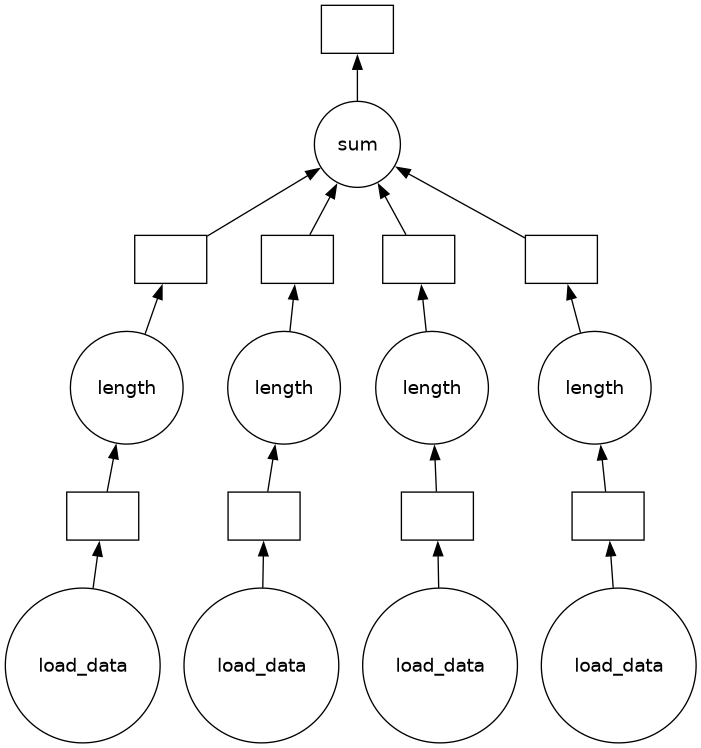

In [14]:
total_number_of_rows.visualize()


The graph can be read from bottom to top. 

We see that for each worker, we will first execute the load_data function to create each dataframe. 

Then the function length will be applied to each dataframe.

The results from these operations on each worker will then be combined into a single result via the sum function.

Let's now execute our workflow and compute a value for the total_number_of_rows variable.


In [15]:
# use the client to compute the result and wait for it to finish
future = client.compute(total_number_of_rows)
wait(future)
future


<Future: finished, type: int, key: sum-bddfce46-a58f-4241-b46e-dbb6dded0530>

We see that our computation has finished - our result is of type int. 

We can collect our result using the client.gather() method.


In [16]:
# collect result
result = client.gather(future)
result


500000000

That's all there is to it! 

We can define even more complex operations and workflows using cuDF DataFrames by using the 

- delayed,
- wait,
- client.submit(), and
- client.gather()

However, there can sometimes be a drawback from using this pattern. 

Consider a common operation such as a groupby.

We might want to group on certain keys and aggregate the values to compute a mean, variance, or even more complex aggregations. 

Each dataframe is located on a different GPU.

We're not guaranteed that all of the keys necessary for that groupby operation are located on a single GPU.

That is keys may be scattered across multiple GPUs.

Let's consider the simple operation of grouping on our key column and calculating the mean of the value column. 

We'd have to sort the data and transfer keys and their associated values from one GPU to another - a tricky thing to do using the delayed pattern. 

In the example below, we'll show an example of this issue with the delayed pattern and motivate why one might consider using the dask_cudf API.

First, let's define a function groupby that takes a cudf.DataFrame, groups by the key column, and calculates the mean of the value column.


In [17]:
def groupby(dataframe):
    return dataframe.groupby('key')['value'].mean()


We'll apply the function groupby to each dataframe using the delayed operation.


In [18]:
groupbys = [delayed(groupby)(df) for df in dfs]


We'll then execute that operation:


In [19]:
# use the client to compute the result and wait for it to finish
groupby_dfs = client.compute(groupbys)
wait(groupby_dfs)
groupby_dfs


[<Future: finished, type: cudf.core.series.Series, key: groupby-3560434e-7459-4e47-bbd4-244bd5e4d89a>,
 <Future: finished, type: cudf.core.series.Series, key: groupby-633619ed-a6bd-48dc-b2f8-f46153d23aea>,
 <Future: finished, type: cudf.core.series.Series, key: groupby-15c36860-4944-4c08-9433-3a707d09ae00>,
 <Future: finished, type: cudf.core.series.Series, key: groupby-8262adbe-2361-4d53-bc65-1671a3f2568e>]

In [20]:
results = client.gather(groupby_dfs)
results


[key
 0   -0.000173
 1   -0.000059
 Name: value, dtype: float64,
 key
 0   -0.000173
 1   -0.000059
 Name: value, dtype: float64,
 key
 0   -0.000173
 1   -0.000059
 Name: value, dtype: float64,
 key
 0   -0.000173
 1   -0.000059
 Name: value, dtype: float64]

In [21]:
for i, result in enumerate(results):
    print('cuDF DataFrame:', i)
    print(result)


cuDF DataFrame: 0
key
0   -0.000173
1   -0.000059
Name: value, dtype: float64
cuDF DataFrame: 1
key
0   -0.000173
1   -0.000059
Name: value, dtype: float64
cuDF DataFrame: 2
key
0   -0.000173
1   -0.000059
Name: value, dtype: float64
cuDF DataFrame: 3
key
0   -0.000173
1   -0.000059
Name: value, dtype: float64


This isn't exactly what we wanted though.

Ideally, we'd get one dataframe where for each unique key (0 and 1), we get the mean of the value column.

We can use the dask_cudf API to help up solve this problem. 

First we'll import the dask_cudf library.

Then use the dask_cudf.from_delayed function to convert our list of delayed dataframes to an object of type dask_cudf.core.DataFrame. 

We'll use this object - distributed_df - along with the dask_cudf API to perform that "tricky" groupby operation.


In [22]:
# create a distributed cuDF DataFrame using Dask
distributed_df = dask_cudf.from_delayed(dfs)
print('Type:', type(distributed_df))
distributed_df


Type: <class 'dask_cudf._expr.collection.DataFrame'>


,key,value
npartitions=4,,
,int64,float64
,...,...
,...,...
,...,...
,...,...


The dask_cudf API closely mirrors the cuDF API. 

We can use a groupby similar to how we would with cuDF - but this time, our operation is distributed across multiple GPUs!


In [23]:
result = distributed_df.groupby('key')['value'].mean().compute()
result


key
0   -0.000173
1   -0.000059
Name: value, dtype: float64

Lastly, let's examine our result!


In [24]:
print(result)


key
0   -0.000173
1   -0.000059
Name: value, dtype: float64


In [25]:
client.close()
